In [ ]:
#Import standard packages for model training

import sklearn as SK
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import *
from skopt import BayesSearchCV
import numpy as np
import pandas as pd
import os 
import io
from tensorboard.plugins.hparams import api as hp
from utils import utils

commons = utils.Commons()
ts_helper = utils.TS_Helper()
shap_helper = utils.Shap_Helper()

ts_helper.model_type = ts_helper.Classification
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "-1"

In [ ]:
#Inport train, validation and test sets

training = './data/Classification/Tb.brucei/scaffold_split/train_fold_4.csv'
validation = './data/Classification/Tb.brucei/scaffold_split/valid_fold_4.csv'
test = './data/Classification/Tb.brucei/scaffold_split/test_fold_4.csv'
TASK_START = 2
NUM_TASKS = 1
SMILES = 'SMILES'
train_dataset,y_train,train_smiles = commons.load_dataset(training,SMILES,TASK_START,NUM_TASKS)
valid_dataset,y_val,val_smiles = commons.load_dataset(validation,SMILES,TASK_START,NUM_TASKS)
test_dataset,y_test,test_smiles = commons.load_dataset(test,SMILES,TASK_START,NUM_TASKS)

train_dataset.head()

In [ ]:
# calculate ECFP (defaut) fingerprints using RDKit
RADIUS = 2 #diameter 4
FP_SIZE = 2048  #bit string size
FEAT = False #used when you consider pharmacophoric features
X_train = commons.assing_fp(train_smiles,FP_SIZE,RADIUS,FEAT)
X_test = commons.assing_fp(test_smiles,FP_SIZE,RADIUS,FEAT)

y_train = y_train.ravel()
y_train = np.array(y_train).astype(int)
y_test = y_test.ravel()
y_test = np.array(y_test).astype(int)

X_train.shape, X_test.shape

In [ ]:
#Parameters for train model

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scorer = make_scorer(mean_squared_error)

#log-uniform: understand as search over p = exp(x) by varying x

model = BayesSearchCV(RandomForestClassifier(),
    {
    'max_features': ['auto', 'sqrt'],
    'n_estimators': [2, 150],
    "max_depth": [2, 10],
    },
    n_iter=2, # Number of parameter settings that are sampled
    cv=cv,
    scoring = scorer,
    refit = True, # Refit the best estimator with the entire dataset.
    random_state=42,
    n_jobs = -1
)

model.fit(X_train, y_train)

print("Best parameters: %s" % model.best_params_)

In [ ]:
#Fit model using best hyperparameters

best_model = RandomForestClassifier(**model.best_params_)
best_model.fit(X_train, y_train)


Confusion matrix: [[47 32]
 [ 7 45]]
Statistic       Value
-----------  --------
Accuracy     0.70229
Precision    0.584416
Recall       0.865385
F1           0.697674
MCC          0.457545
Kappa        0.425374
SE           0.865385
SP           0.594937
PPV          0.584416
NPV          0.87037
TPR          0.865385
FPR          0.405063
[[47 32]
 [ 7 45]]


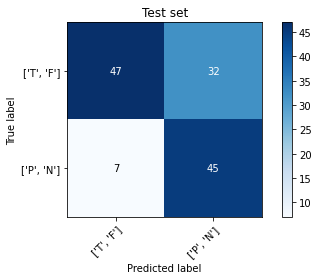

In [7]:
#Statistical characteristics of model

y_pred_train = (model.predict_proba(X_train)[:,1] >= 0.5).astype(bool)
y_pred_test = (model.predict_proba(X_test)[:,1] >= 0.5).astype(bool)

#ts_helper.get_modeStatsFor_Train_Test(model,X_train,y_pred_train,X_test,y_pred_test)

prediction_df = pd.DataFrame({'SMILES': test_smiles, 'y': y_test, 'pred': y_pred_test})
confusion, (TP, TN, FP, FN) = ts_helper.calc_confusion_matrix(prediction_df)

text,_  =  ts_helper.calc_Statistics(TP, TN, FP, FN, prediction_df)

print(text)

ts_helper.plot_Classification(confusion,[['T','F'],["P","N"]],title='Test set')


# confusion = confusion_matrix(y_train, y_pred_train)
#       #[row, column]
# TP = confusion[1, 1]
# TN = confusion[0, 0]
# FP = confusion[0, 1]
# FN = confusion[1, 0]

# print(("Train set results"))
# print("ACC\t%.2f" % ((TN+TP)/(TN+TP+FN+FP)))
# print("MCC\t%.2f" % matthews_corrcoef(y_train, y_pred_train))
# #print("kappa\t%.2f" % cohen_kappa_score(y_train, y_pred_train))
# print("SE\t%.2f" % (TP/(TP+FN)))
# print("SP\t%.2f" % (TN/(TN+FP)))
# #print("PPV\t%.2f" % (TP/(TP+FP)))
# #print("NPV\t%.2f" % (TN/(TN+FN)))
# #print("TPR\t%.2f" %(TP/(TP+FN)))
# #print("FPR\t%.2f" %(FP/(FP+TN)))
# #print("F1\t%.2f" % f1_score(y_train, y_pred_train))


# confusion_test = confusion_matrix(y_test, y_pred_test)
#     #[row, column]
# TP_test = confusion_test[1, 1]
# TN_test = confusion_test[0, 0]
# FP_test = confusion_test[0, 1]
# FN_test = confusion_test[1, 0]

# print(("Test set results"))
# print("ACC\t%.2f" % ((TN_test+TP_test)/(TN_test+TP_test+FN_test+FP_test)))
# print("MCC\t%.2f" % matthews_corrcoef(y_test, y_pred_test))
# #print("kappa\t%.2f" % cohen_kappa_score(y_test, y_pred_test))
# print("SE\t%.2f" % (TP_test/(TP_test+FN_test)))
# print("SP\t%.2f" % (TN_test/(TN_test+FP_test)))
# #print("PPV\t%.2f" % (TP_test/(TP_test+FP_test)))
# #print("NPV\t%.2f" % (TN_test/(TN_test+FN_test)))
# #print("TPR\t%.2f" %(TP_test/(TP_test+FN_test)))
# #print("FPR\t%.2f" %(FP_test/(FP_test+TN_test)))
# #print("F1\t%.2f" % f1_score(y_test, y_pred_test))
